<a href="https://www.kaggle.com/code/hseyinkalkan/spaceshiptitanic-xgbclassifier-optuna?scriptVersionId=149205955" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Library

In [1]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load Data

In [2]:
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
sample = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")

In [3]:
train_test = pd.concat([train, test], ignore_index=True)

In [4]:
train_test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


# Data Analysis and Feature Engineering

* PassengerId

In [5]:
train_test['Group'] = train_test['PassengerId'].astype(str).str[:4]

In [6]:
counts = train_test['Group'].value_counts()
train_test['Group'] = train_test['Group'].map(counts)

In [7]:
train_test.groupby('Group')['Transported'].mean()

Group
1    0.452445
2    0.538050
3    0.593137
4    0.640777
5    0.592453
6    0.614943
7    0.541126
8    0.394231
Name: Transported, dtype: float64

There seem to be differences between the groups. This can help predict the target variable.

* Cabin

In [8]:
train_test[['Deck', 'Number', 'Side']] = train_test['Cabin'].str.split('/', expand=True)

In [9]:
train_test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,Number,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,2,A,0,S


*   RoomService , FoodCourt , ShoppingMall , Spa, VRDeck

<Figure size 1200x600 with 0 Axes>

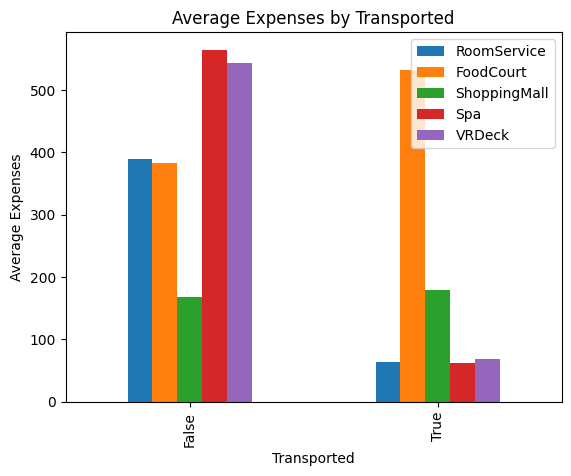

In [10]:
Expenses_columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']


expenses_grouped = train.groupby('Transported')[Expenses_columns].mean()

plt.figure(figsize=(12, 6))
expenses_grouped.plot(kind='bar')
plt.xlabel('Transported')
plt.ylabel('Average Expenses')
plt.title('Average Expenses by Transported')
plt.legend(Expenses_columns)
plt.show()

ShoppingMall, It doesn't look like a useful property for the target variable.

Lets create a new feature from 'RoomService','FoodCourt','Spa' and 'VRDeck' features.

In [11]:
Expenses_columns = ['RoomService','FoodCourt','Spa','VRDeck','ShoppingMall']
train_test['Expenses'] = train_test.loc[:,Expenses_columns].sum(axis=1)

If "Cryosleep" = 1, Expense = 0

In [12]:
train_test.loc[:,['CryoSleep']]=train_test.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x,axis =1)

<AxesSubplot: xlabel='Transported'>

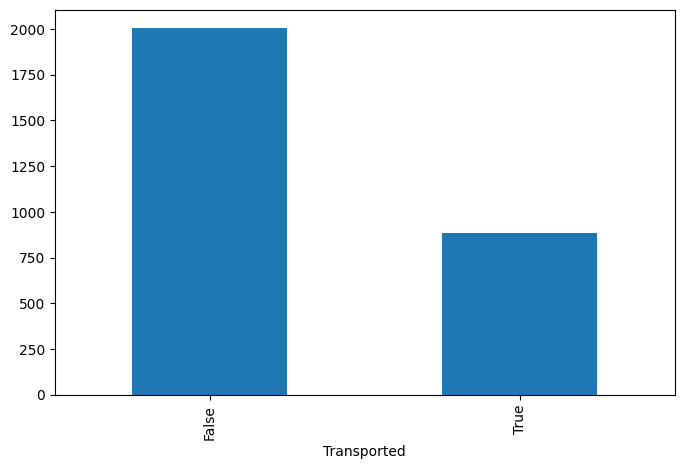

In [13]:
expenses_grouped = train_test.groupby('Transported')["Expenses"].mean()
plt.figure(figsize=(8, 5))
expenses_grouped.plot(kind='bar')

There is a difference between " transported " groups according to the "Expenses".

* HomePlanet

In [14]:
train_test.groupby('HomePlanet')['Transported'].mean()

HomePlanet
Earth     0.423946
Europa    0.658846
Mars      0.523024
Name: Transported, dtype: float64

* Destination

In [15]:
train_test.groupby('Destination')['Transported'].mean()

Destination
55 Cancri e      0.610000
PSO J318.5-22    0.503769
TRAPPIST-1e      0.471175
Name: Transported, dtype: float64

* CryoSleep

In [16]:
train_test.groupby('CryoSleep')['Transported'].mean()

CryoSleep
False    0.328921
True     0.814673
Name: Transported, dtype: float64

* Age

In [17]:
train_test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,Number,Side,Expenses
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,B,0,P,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,F,0,S,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,2,A,0,S,10383.0


In [18]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age']
cat_cols = ['CryoSleep','Deck','Side','VIP','HomePlanet','Destination',"Group"]
transported=['Transported']

In [19]:
train_test = train_test[num_cols+cat_cols+transported].copy()

In [20]:
train_test.head()

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Expenses,Age,CryoSleep,Deck,Side,VIP,HomePlanet,Destination,Group,Transported
0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,False,B,P,False,Europa,TRAPPIST-1e,1,False
1,25.0,9.0,109.0,549.0,44.0,736.0,24.0,False,F,S,False,Earth,TRAPPIST-1e,1,True
2,0.0,3576.0,43.0,6715.0,49.0,10383.0,58.0,False,A,S,True,Europa,TRAPPIST-1e,2,False
3,371.0,1283.0,0.0,3329.0,193.0,5176.0,33.0,False,A,S,False,Europa,TRAPPIST-1e,2,False
4,151.0,70.0,303.0,565.0,2.0,1091.0,16.0,False,F,S,False,Earth,TRAPPIST-1e,1,True


# Missing Values

In [21]:
num_imp = SimpleImputer(strategy='mean')
cat_imp = SimpleImputer(strategy='most_frequent')

In [22]:
train_test[num_cols] = pd.DataFrame(num_imp.fit_transform(train_test[num_cols]),columns=num_cols)
train_test[cat_cols] = pd.DataFrame(cat_imp.fit_transform(train_test[cat_cols]),columns=cat_cols)

* Age

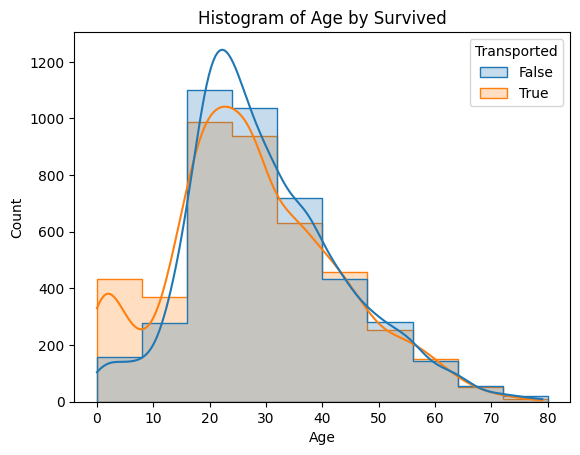

In [23]:
sns.histplot(data=train, x='Age', hue='Transported', element='step', kde=True,binwidth=8)
plt.title('Histogram of Age by Survived')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [24]:
# Age değişkenini gruplayalım
train_test['Age_group'] = 0
train_test.loc[train_test['Age']  <= 5, 'Age_group'] = 1
train_test.loc[(train_test['Age'] > 5) & (train_test['Age'] <= 10), 'Age_group']=2
train_test.loc[(train_test['Age'] > 10) & (train_test['Age'] <= 20), 'Age_group']=3
train_test.loc[(train_test['Age'] > 20) & (train_test['Age'] <= 30), 'Age_group']=4
train_test.loc[(train_test['Age'] > 30) & (train_test['Age'] <= 50), 'Age_group']=5
train_test.loc[(train_test['Age'] > 50) & (train_test['Age'] <= 60), 'Age_group']=6
train_test.loc[(train_test['Age'] > 60) & (train_test['Age'] <= 70), 'Age_group']=7
train_test.loc[train_test['Age']  > 70, 'Age_group'] = 8

In [25]:
train_test.groupby('Age_group')['Transported'].mean()

Age_group
1    0.757515
2    0.593607
3    0.517764
4    0.471373
5    0.479432
6    0.489362
7    0.491803
8    0.378378
Name: Transported, dtype: float64

In [26]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age']
cat_cols = ['CryoSleep','Deck','Side','VIP','HomePlanet','Destination',"Group","Age_group"]
transported=['Transported']
train_test = train_test[num_cols+cat_cols+transported].copy()

## One-Hot Encoding :  Catagoric Features

In [27]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder (handle_unknown='ignore',sparse_output = False)
temp_train = pd.DataFrame(ohe.fit_transform(train_test[cat_cols]),columns=ohe.get_feature_names_out())
train_test = train_test.drop(cat_cols,axis=1)
train_test = pd.concat([train_test,temp_train],axis=1)

### Getting Test and Train Data

In [28]:
train = train_test[train_test['Transported'].notnull()].copy()
train.Transported =train.Transported.astype('int')
test = train_test[train_test['Transported'].isnull()].drop("Transported",axis=1)

In [29]:
X = train.drop('Transported',axis=1)
y = train.Transported

 ### Most corrolated features

In [30]:
def get_redundant_pairs(X):
    pairs_to_drop = set()
    cols = X.columns
    for i in range(0, X.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
def get_top_abs_correlations(df, n=1):
    au_corr = X.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(X)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]
print("Top Absolute Correlations !")
print(get_top_abs_correlations(train.select_dtypes(include=['int32','int64']), 10))

Top Absolute Correlations !
CryoSleep_False          CryoSleep_True             1.000000
VIP_False                VIP_True                   1.000000
Side_P                   Side_S                     1.000000
Destination_55 Cancri e  Destination_TRAPPIST-1e    0.783137
FoodCourt                Expenses                   0.742073
HomePlanet_Earth         HomePlanet_Europa          0.633221
Spa                      Expenses                   0.592425
VRDeck                   Expenses                   0.584706
Deck_G                   HomePlanet_Earth           0.581275
HomePlanet_Earth         HomePlanet_Mars            0.559658
dtype: float64


* Deleting one of the variables with the highest correlation prevents multicorrelation.

    These Feature can delete:
    
    CryoSleep_True , VIP_False , Side_P , Destination_TRAPPIST-1e   , FoodCourt  ,HomePlanet_Earth
    
* We have seen before that 'ShoppingMall' will contribute to the model.

* We used the "Age" variable as  "Age_group" ,we will delete this too


In [31]:
drop_list=['ShoppingMall',"Age",'CryoSleep_True','HomePlanet_Earth',
'VIP_False','FoodCourt','Destination_TRAPPIST-1e', "Side_P"]

In [32]:
X=X.drop(drop_list,axis=1)
test=test.drop(drop_list,axis=1)

In [33]:
X.columns

Index(['RoomService', 'Spa', 'VRDeck', 'Expenses', 'CryoSleep_False', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Side_S', 'VIP_True', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Group_1',
       'Group_2', 'Group_3', 'Group_4', 'Group_5', 'Group_6', 'Group_7',
       'Group_8', 'Age_group_1', 'Age_group_2', 'Age_group_3', 'Age_group_4',
       'Age_group_5', 'Age_group_6', 'Age_group_7', 'Age_group_8'],
      dtype='object')

# Selection Model

In [34]:
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 2
classifiers = [SVC(),RandomForestClassifier(), ExtraTreesClassifier(),GradientBoostingClassifier(),
    KNeighborsClassifier(), CatBoostClassifier(verbose = False),
    XGBClassifier(), LGBMClassifier()]

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X, y = y, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC", "RandomForest","ExtraTrees","GradientBoosting"
                                                                                      ,"KNeighboors", "CatBoostClassifier",
                                                                                      "XGBClassifier", "LGBMClassifier"]})

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [35]:
cv_res 

,CrossValMeans,CrossValerrors,Algorithm
0,0.788568,0.014188,SVC
1,0.789029,0.011089,RandomForest
2,0.759349,0.009625,ExtraTrees
3,0.795357,0.015611,GradientBoosting
4,0.762223,0.013761,KNeighboors
5,0.809276,0.011920,CatBoostClassifier
6,0.800535,0.016571,XGBClassifier
7,0.803295,0.015031,LGBMClassifier


I will select XGBClassifier and proceed.

# Feature Selection

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

# Train the LightGBM model
model = lgb.LGBMClassifier()
model.fit(X, y)

# Get permutation materiality
result = permutation_importance(model, X_val, y_val, scoring="accuracy", n_repeats=100, random_state=42)
sorted_indices = np.argsort(result.importances_mean)[::-1]

# Show the most important features and their respective importance values
top_features = X.columns[sorted_indices[:15]]  # Most 15 importend feature
top_importances = result.importances_mean[sorted_indices[:15]]
for feature, importance in zip(top_features, top_importances):
    print(f"{feature}: {importance}")

VRDeck: 0.08443933294997119
Spa: 0.07597469810235763
RoomService: 0.07476710753306492
Expenses: 0.05392754456584241
CryoSleep_False: 0.04238067855089127
Side_S: 0.014997124784358787
Deck_C: 0.014312823461759595
Deck_F: 0.012840713053478968
Deck_E: 0.012259919493962004
Destination_55 Cancri e: 0.007188039102932669
HomePlanet_Mars: 0.00699827487061525
Deck_B: 0.005859689476710703
Deck_G: 0.004261069580218462
Group_1: 0.0041230592294421615
Group_2: 0.002978723404255261


In [37]:
top_features

Index(['VRDeck', 'Spa', 'RoomService', 'Expenses', 'CryoSleep_False', 'Side_S',
       'Deck_C', 'Deck_F', 'Deck_E', 'Destination_55 Cancri e',
       'HomePlanet_Mars', 'Deck_B', 'Deck_G', 'Group_1', 'Group_2'],
      dtype='object')

# Model Tunnig with OPTUNA

In [38]:
# Let's move on with the top 20 features
X = X[top_features]
test = test[top_features]

In [39]:
#import necessary libraries
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier



#define objective function for hyperparameter optimization using optuna
def objective(trial):

  #define hyperparameters to optimize for
  params = {
      'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
      'max_depth': trial.suggest_int('max_depth', 3, 10),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 1),
      'subsample': trial.suggest_uniform('subsample', 0.1, 1),
      'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
      #'gamma': trial.suggest_uniform('gamma', 0, 1),
      'alpha': trial.suggest_loguniform('alpha', 2, 5),
      'lambda': trial.suggest_loguniform('lambda', 2, 5),
      'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
  }

  #create XGBClassifier model with optimized hyperparameters
  model = XGBClassifier(**params, random_state=0)
    
  #evaluate model using cross-validation
  score = cross_val_score(model, X, y, cv=5).mean()
    
  return score

#run hyperparameter optimization with optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2023-11-03 18:31:00,572] A new study created in memory with name: no-name-e3ca5d67-6c63-4da0-9374-ce658a7db154
[I 2023-11-03 18:31:16,602] Trial 0 finished with value: 0.7468104958274633 and parameters: {'n_estimators': 908, 'max_depth': 6, 'learning_rate': 0.011916051880732111, 'subsample': 0.6550170515648253, 'colsample_bytree': 0.9899342103266016, 'alpha': 3.9802494150727528, 'lambda': 3.2884761092824677, 'min_child_weight': 284}. Best is trial 0 with value: 0.7468104958274633.
[I 2023-11-03 18:31:20,902] Trial 1 finished with value: 0.7603830356321604 and parameters: {'n_estimators': 292, 'max_depth': 10, 'learning_rate': 0.764503716230614, 'subsample': 0.5850306815976255, 'colsample_bytree': 0.6128955396307922, 'alpha': 4.188685220032133, 'lambda': 3.131964008167195, 'min_child_weight': 203}. Best is trial 1 with value: 0.7603830356321604.
[I 2023-11-03 18:31:26,734] Trial 2 finished with value: 0.7361129069720505 and parameters: {'n_estimators': 464, 'max_depth': 9, 'learning_

In [40]:
#get best hyperparameters
best_params = study.best_params
print(f'Best hyperparameters: {best_params}')

Best hyperparameters: {'n_estimators': 535, 'max_depth': 8, 'learning_rate': 0.06589469808784075, 'subsample': 0.39784347417921767, 'colsample_bytree': 0.8052639278331227, 'alpha': 4.7327779162243155, 'lambda': 2.2745647874514137, 'min_child_weight': 1}


I found the best parameters by running "n trials=500" on the local computer.It will take too much time to do this here.

As follows:

In [41]:
best_params= {'n_estimators': 465, 
              'max_depth': 4, 
              'learning_rate': 0.13566308331651933,
              'subsample': 0.6217729332313746,
              'colsample_bytree': 0.9406231273240503,
              'alpha': 3.8470299829756747,
              'lambda': 2.6061951769367186,
              'min_child_weight': 6}

In [42]:
#create XGBClassifier model with best hyperparameters
model = XGBClassifier(**best_params, random_state=0)

In [43]:
#fit and predict using model
model.fit(X, y)
predictions = model.predict(test)

In [44]:
sample['Transported'] = predictions
#This converts the numbers to True/False values
sample['Transported']=sample['Transported']>0.5
sample.to_csv('final.csv', index=False)

### Next

Hyperparameter optimization trials can be done for CatBoostClassifier and LGBMClassifier to achieve better results with high number of trials